In [1]:
import os
import random
import h5py
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import fenton_karma as fk

## SEPARATE DIFFUSION AND REACTION TERM

In [2]:
# simulation inputs (real values)
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/"
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = fk.params.paramset_3

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

# diffusivity 
d = 0.001  # cm^2/ms
shape = fk.convert.realsize_to_shape(field_size, dx)
diffusivity = np.ones(shape) * d

In [3]:
name = root + "train_dev_set/deepreact_spiral_params5.hdf5"

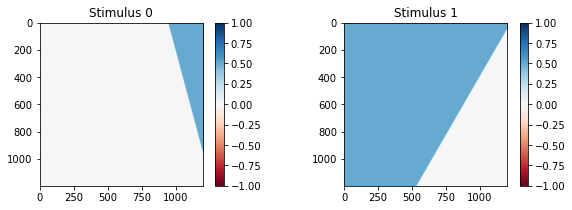

In [4]:
# times
start = 0  # ms
stop = 2000  # ms
show_every = 50  # ms

# stimuli
s1 = fk.stimulus.Protocol(start=0, duration=2, period=1e9)
s1 = fk.stimulus.triangular(shape, direction="right", angle=15, coverage=0.1, modulus=0.5, protocol=s1)

s2 = fk.stimulus.Protocol(start=fk.convert.ms_to_units(400, dt), duration=2, period=1e9)
s2 = fk.stimulus.triangular(shape, direction="up", angle=60, coverage=0.7, modulus=0.5, protocol=s2)

# s3 = fk.stimulus.protocol(start=fk.convert.ms_to_units(900, dt), duration=2)
# s3 = fk.stimulus.triangular(shape, direction="down", angle=30, coverage=0.7, modulus=1., protocol=s3)

stimuli = [s1, s2]
fk.plot.show_stimuli(*stimuli)

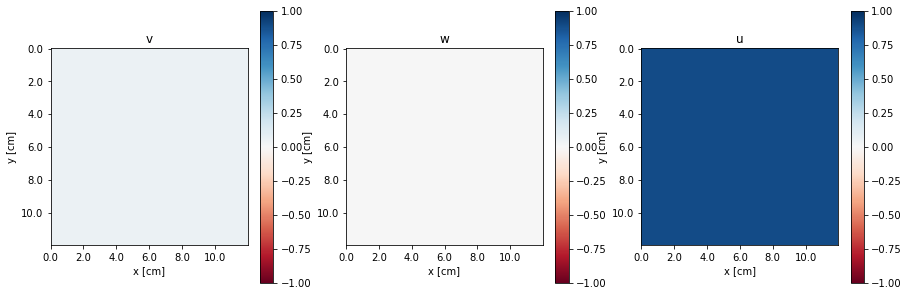

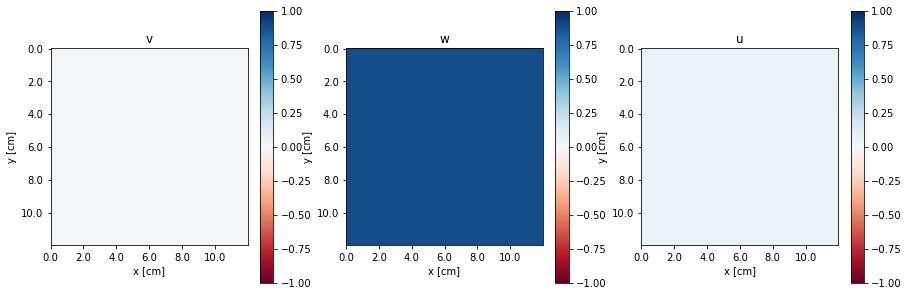

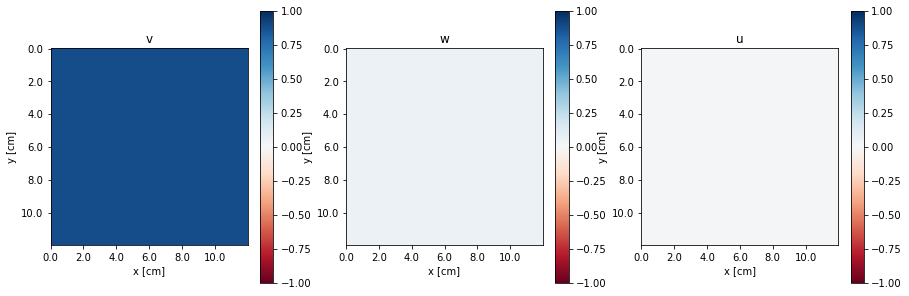

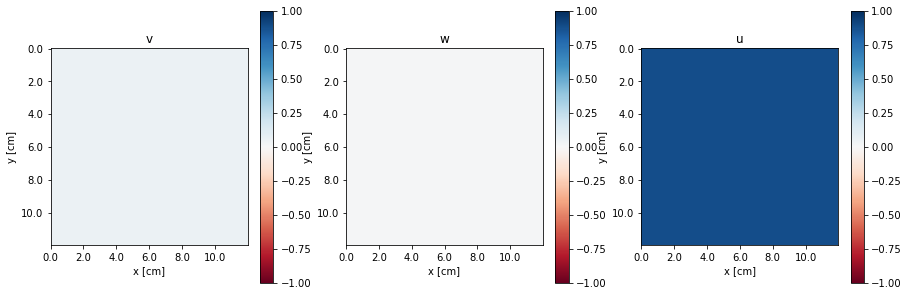

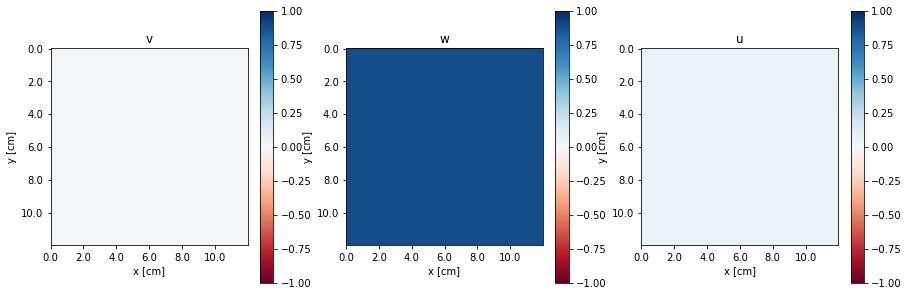

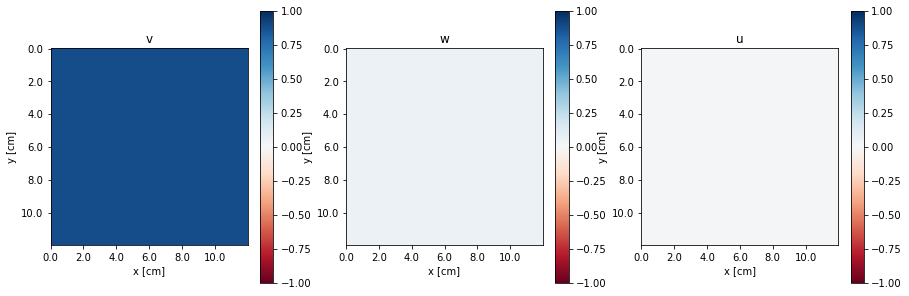

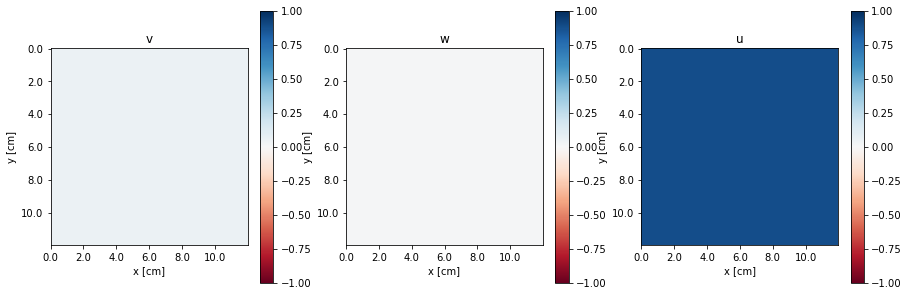

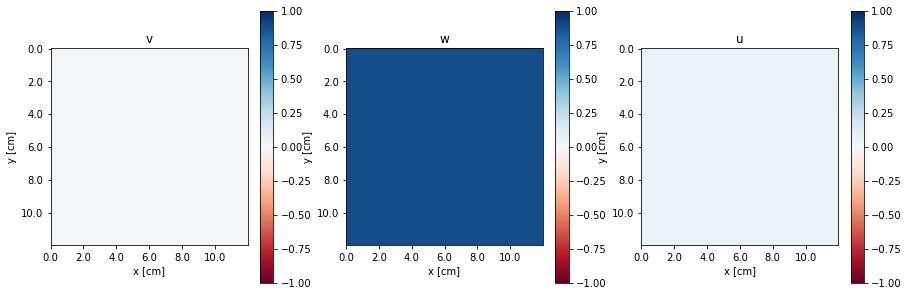

KeyboardInterrupt: 

In [5]:
checkpoints = np.arange(start // dt, (stop - start) // dt, show_every // dt)
states = fk.model.forward(shape, checkpoints, cell_parameters, diffusivity, stimuli, dt, dx)

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename=name)

In [ ]:
# display
with h5py.File(name, "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

V = fk.convert.u_to_V(states[:, 2])
fig, ax = fk.plot.show_grid(V, figsize=(25, 25), font_size=18)

In [ ]:
a = jax.numpy.ones((6, 6))
a

In [ ]:
import numpy
a = numpy.random.randint(0, high=20, size=(3, 3))
a

In [ ]:
b = jax.numpy.pad(a, 1, mode="edge")
b

In [ ]:
b.shape

In [ ]:
b[1:-1, 1:-1]

In [ ]:
import jax
from typing import NamedTuple


@jax.jit
def forward(state, start, end):
    # iterate
    state = jax.lax.fori_loop(start, end, lambda i, state: step(state), init_val=state)
    return state

@jax.jit
def step(state):
    state = state + jax.numpy.log1p(state)
    state = state + jax.numpy.exp(state)
    state = jax.ops.index_update(state, jax.ops.index[0], state[1])
    state = jax.ops.index_update(state, jax.ops.index[-1], state[-2])
    state = jax.ops.index_update(state, jax.ops.index[..., 0], state[..., 1])
    state = jax.ops.index_update(state, jax.ops.index[..., -1], state[..., -2])
    return state

In [ ]:
a = jax.numpy.ones((1200, 1200))

state = jax.numpy.array(a)
forward(state, 0, 10000)